In [15]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor    
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

In [8]:
# Dataset 
set_config(transform_output='pandas')

In [9]:
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

In [10]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [11]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [12]:
# Spliting the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))

In [13]:
# Model
model = XGBRegressor(objective='reg:squarederror', random_state=42,
                     n_jobs = -1, learning_rate=0.2, n_estimators=200,
                    reg_lambda=50, max_depth=7,gamma=0.05)

In [14]:
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
# accuracy calculation for  test data 
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 0.44741869665737694
R2: 0.8472358680056411


In [48]:
# Hyper parameter tuning with Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'sub_sample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    return r2

In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-18 21:42:39,958] A new study created in memory with name: no-name-760f72a2-f1ce-4827-bc9a-ae810ca92770
[I 2025-12-18 21:42:40,023] Trial 0 finished with value: 0.8233928604970602 and parameters: {'learning_rate': 0.19788862703510782, 'n_estimators': 71, 'reg_lambda': 68.10796261545657, 'max_depth': 7, 'gamma': 0.8416095762213978, 'subsample': 0.7953937325487719}. Best is trial 0 with value: 0.8233928604970602.
[I 2025-12-18 21:42:40,115] Trial 1 finished with value: 0.8039628907115937 and parameters: {'learning_rate': 0.16766256228154405, 'n_estimators': 468, 'reg_lambda': 59.46725715358341, 'max_depth': 6, 'gamma': 1.8931125475397828, 'subsample': 0.8328602280522528}. Best is trial 0 with value: 0.8233928604970602.
[I 2025-12-18 21:42:40,233] Trial 2 finished with value: 0.8361025747413482 and parameters: {'learning_rate': 0.15207537467408425, 'n_estimators': 186, 'reg_lambda': 71.4320916156587, 'max_depth': 8, 'gamma': 0.28261717665547725, 'subsample': 0.8959309943711253}.

In [50]:
study.best_params

{'learning_rate': 0.20233410569296625,
 'n_estimators': 267,
 'reg_lambda': 98.82306902261561,
 'max_depth': 10,
 'gamma': 0.0007016128961792947,
 'subsample': 0.9244564923979541}

In [ ]:
study.best_value # best r2_score 

0.8515926579527775

In [53]:
# training the model with best parameters
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
# Print the metrics for best model for train data and test data
y_pred_best = best_model.predict(X_test)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Best Model RMSE: {rmse_best}")
print(f"Best Model R2: {r2_best}")

# train data results
y_train_pred = best_model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f"Train Data RMSE: {rmse_train}")
print(f"Train Data R2: {r2_train}")
# Overfitting is visibile

Best Model RMSE: 0.44440845706691223
Best Model R2: 0.8492845516231755
Train Data RMSE: 0.15851347945290004
Train Data R2: 0.9812036709256128


# Shap

In [55]:
# model specific explainability with SHAP
explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [56]:
# expectee value (base value)
explainer.expected_value

np.float64(2.002648046883037)

In [65]:
# calculating the shap values for all the X_test data
shap_values = explainer(X_test)
shap_values.shape

 99%|===================| 4107/4128 [01:41<00:00]        

(4128, 8)

## Global Interpretation

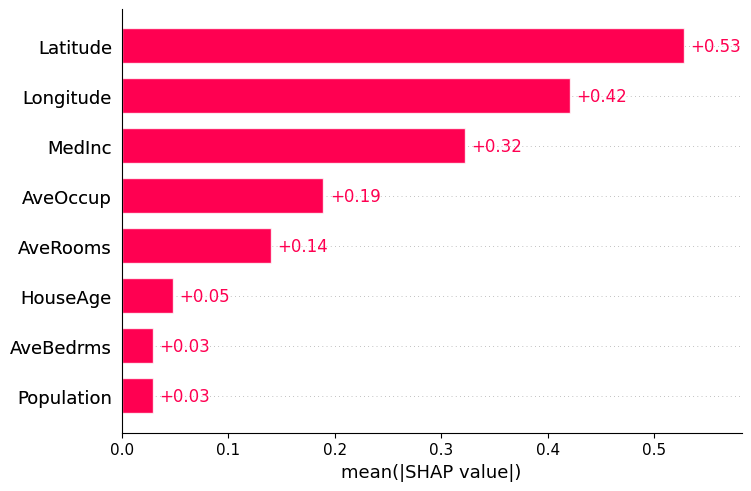

In [66]:
## feature importance plot
shap.plots.bar(shap_values=shap_values)

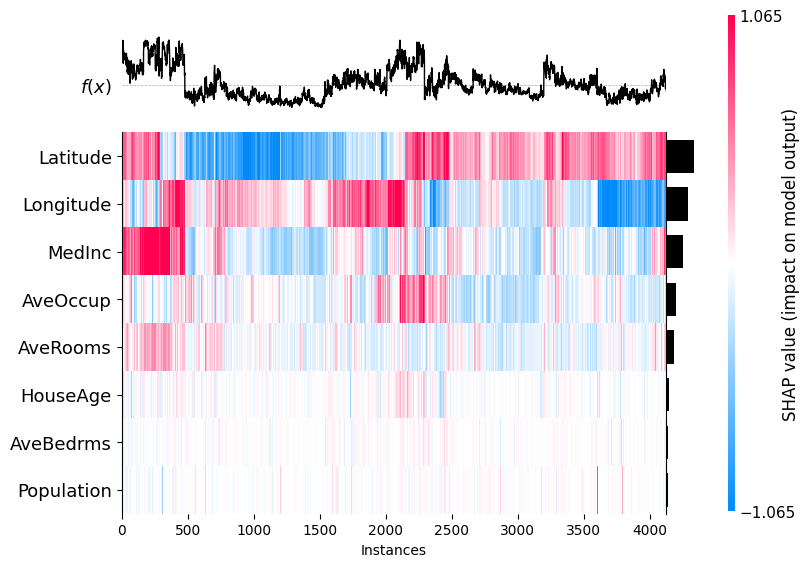

<Axes: xlabel='Instances'>

In [ ]:
## Heatmap for shap values
## Shuld not be used for complete dataset as it becomes clutered + time consuming
shap.plots.heatmap(shap_values)

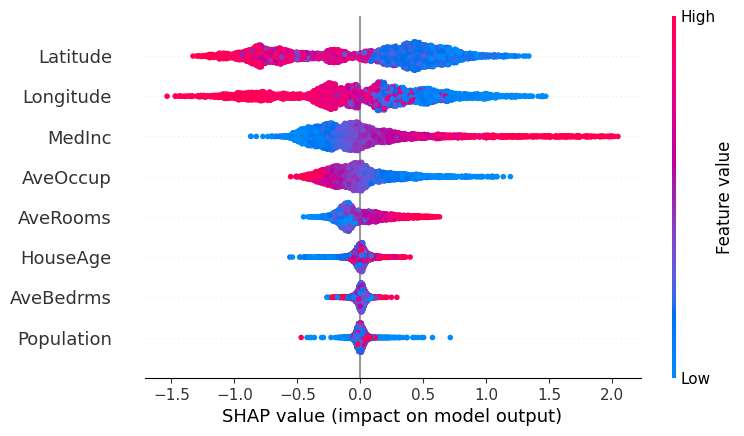

In [71]:
# Summary plot/beeswarm plot
shap.plots.beeswarm(shap_values)

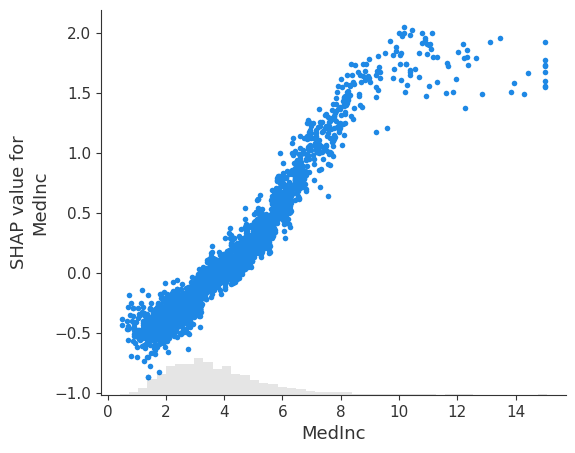

In [72]:
# Scatter plot for MedInc (Dependence plot) -- Explanation for a single feature
shap.plots.scatter(shap_values[:, "MedInc"])

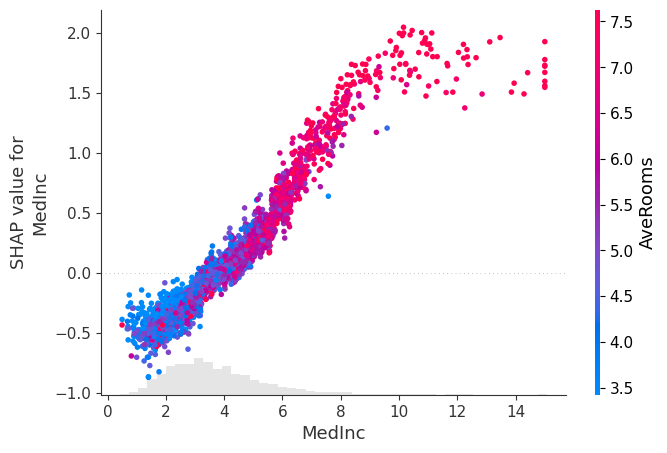

In [73]:
# using color to show interaction effects
shap.plots.scatter(shap_values[:, "MedInc"],
                   color=shap_values[:, "AveRooms"])